In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
class XgramWordGenerator:
    def __init__(self, file_path, x):
        # Read words from the .txt file, add special token '.'
        with open(file_path, 'r') as f:
            self.words = ['.' + word.strip().lower() + '.' for word in f.readlines()]
        self.x = x
        self.char_to_idx = {}
        self.idx_to_char = {}
        self._create_xgram_probs()

    def _create_xgram_probs(self):
        # Create a set of all characters
        characters = set(''.join(self.words))

        # Create character to index mappings, and vice versa
        for i, char in enumerate(characters):
            self.char_to_idx[char] = i
            self.idx_to_char[i] = char

        # Count x grams
        xgram_counts = np.zeros((len(characters),) * self.x)
        # add tiny value to avoid zero probabilities
        xgram_counts += 1e-10
        for word in self.words:
            for i in range(len(word) - self.x + 1):
                xgram = word[i:i + self.x]
                xgram_counts[tuple(self.char_to_idx[c] for c in xgram)] += 1

        # Normalize counts to get probabilities
        self.xgram_probs = xgram_counts / xgram_counts.sum(axis=-1, keepdims=True)

    def get_neg_log_likelihood(self, word):
        result = 0
        word = '.' + word.strip().lower() + '.'
        for i in range(len(word) - self.x):
            xgram = word[i:i + self.x]
            result += np.log(self.xgram_probs[tuple(self.char_to_idx[c] for c in xgram)])
        return -result

    def _generate_initial_chars(self):
        initial_chars = ['.']
        for i in range(1, self.x - 1):
            current_char_probs = self.xgram_probs
            for c in initial_chars[-i:]:
                current_char_probs = current_char_probs[self.char_to_idx[c]]
            current_char_probs = current_char_probs.sum(axis=tuple(range(1, self.x - i)))
            current_char_probs /= current_char_probs.sum()  # Normalize the probabilities
            current_char_probs[self.char_to_idx['.']] = 0  # Exclude '.' character
            current_char_probs /= current_char_probs.sum()  # Re-normalize the probabilities
            next_char_idx = np.random.multinomial(1, current_char_probs).argmax()
            initial_chars.append(self.idx_to_char[next_char_idx])
        return initial_chars

    def generate_word(self, max_word_length):
        generated_word = self._generate_initial_chars()

        for _ in range(max_word_length - 1):
            xgram = generated_word[-(self.x - 1):]
            xgram_indices = [self.char_to_idx[c] for c in xgram]

            if len(xgram_indices) < self.x - 1:
                xgram_indices += [slice(None)] * (self.x - 1 - len(xgram_indices))
                xgram_probs = self.xgram_probs[tuple(xgram_indices)].sum(axis=tuple(range(-(self.x - 1 - len(xgram)), 0)))
            else:
                xgram_probs = self.xgram_probs[tuple(xgram_indices)]

            next_char_idx = np.random.multinomial(1, xgram_probs).argmax()
            next_char = self.idx_to_char[next_char_idx]
            if next_char == '.':
                break
            generated_word.append(next_char)

        return ''.join(generated_word[1:]), self.get_neg_log_likelihood(''.join(generated_word[1:]))

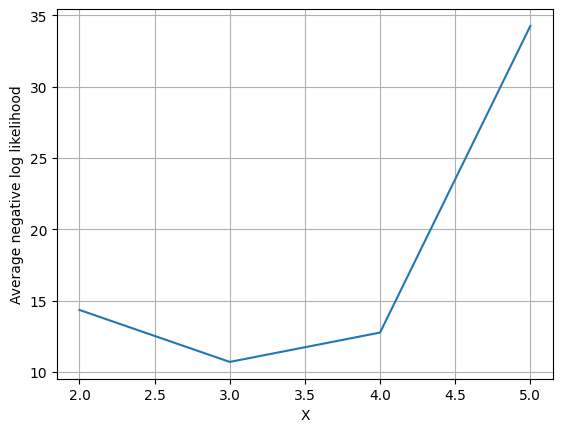

In [10]:
# plot the negative log likelihoods of X=2 to X=5
x_values = list(range(2, 6))
models = []
y_values = []
max_word_length = 30
num_words = 100
for x in x_values:
    xgram_name_generator = XgramWordGenerator('data/names.txt', x)
    generated_words = [xgram_name_generator.generate_word(max_word_length) for _ in range(num_words)]
    df = pd.DataFrame(generated_words, columns=['word', 'neg_log_likelihood'])
    df.sort_values(by='neg_log_likelihood', inplace=True)
    df.reset_index(drop=True, inplace=True)
    y_values.append(df.neg_log_likelihood.mean())
    models.append(xgram_name_generator)

plt.plot(x_values, y_values)
plt.xlabel('X')
plt.ylabel('Average negative log likelihood')
plt.grid()
plt.show()

In [11]:
# list of (X, neg_log_likelihood) tuples
list(zip(x_values, y_values))

[(2, 14.353057739320356),
 (3, 10.71160144008808),
 (4, 12.767096105320874),
 (5, 34.24541616853153)]

In [14]:
# list of (X, % uniform probability) tuples
list(zip(x_values, [round(np.count_nonzero(model.xgram_probs.flatten() == 1/27) / 27**x * 100, 4) for model in models]))

[(2, 0.0), (3, 0.0241), (4, 2.6391), (5, 95.9062)]

The reason why 4-gram and 5-gram perform worse than 3-gram is due to data sparsity. As shown in the previous cell, 95% of all the probabilities in 5-gram are uniform (1/27, or no better than a random guess). 3-gram has the best performance because it has enough context without being too sparse. It is also much faster to train and test.

In "A Neural Probabilistic Language Model" by Bengio et al., it mentions "Typically researchers have used n = 3, i.e. trigrams, and obtained state-of-the-art results".

To solve the data sparsity problem, we can try using backoff (ex. 5-gram -> 4-gram -> 3-gram).